# Overview: Telecom Customer Churn Prediction

This notebook demonstrates a complete workflow for a churn prediction project for a telecom form. We will:
- Import the data and convert columns to the appropriate data types based on the data dictionary.
- Perform exploratory data analysis (EDA) including descriptive statistics, missing value analysis, outlier detection, and correlation matrix visualization.
- Perform feature engineering including missing value imputation, outlier removal (using the IQR method), and encoding.
- Use SMOTE to upsample the minority class due to class imbalance, with class distribution visualizations before and after SMOTE.
- Build and evaluate various classification models (Logistic Regression, K-Nearest Neighbors, Decision Tree, Random Forest, Gradient Boosting, XGBoost, and LightGBM) and report accuracy, precision, recall, and F1 scores.
- Perform hyperparameter tuning and select the best model based on F1 score and explainability.
- Save the best model as a pickle file and plot the ROC-AUC curve for the best model.

# Setup

In [3]:
#Setup 
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt  
import seaborn as sns  
# Display settings  
%matplotlib inline  
pd.set_option('display.max_columns', None)  
pd.set_option('display.max_rows', None)  

# Scikit-learn modules  
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score  
from sklearn.metrics import (classification_report, accuracy_score, precision_score,  
                             recall_score, f1_score, roc_auc_score, roc_curve)  

# Machine learning models  
from sklearn.linear_model import LogisticRegression  
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.tree import DecisionTreeClassifier  
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier  
from xgboost import XGBClassifier  
from lightgbm import LGBMClassifier  
from scipy import stats
from sklearn.metrics import roc_curve, auc

# Imbalanced data handling  
from imblearn.over_sampling import SMOTE 
from sklearn.preprocessing import MinMaxScaler, StandardScaler


# Utilities  
import pickle  
import warnings  
import random

#Kaggle for importing dataset

import kagglehub
from kagglehub import KaggleDatasetAdapter

# Suppress warnings  
warnings.filterwarnings("ignore", category=DeprecationWarning)  
warnings.filterwarnings("ignore", category=FutureWarning)  
warnings.filterwarnings("ignore", category=UserWarning)  



# Data Loading

In [4]:
#Loading dataset from Kaggle 

file_path = "WA_Fn-UseC_-Telco-Customer-Churn.csv"

# Load the dataset directly as a pandas DataFrame
df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "blastchar/telco-customer-churn",
    file_path,
)

# Data Overview

display(df.head())
display(df.info())

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


None

# Data Profiling

In [5]:
# Clean column: TotalCharges
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Check how many were coerced to NaN
print("Missing TotalCharges:", df['TotalCharges'].isna().sum())

# Drop or impute missing TotalCharges
# Here, we'll drop for simplicity
df.dropna(subset=['TotalCharges'], inplace=True)

# Identify categorical columns (object or binary int)
categorical_cols = [
    'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
    'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
    'PaperlessBilling', 'PaymentMethod', 'Churn', 'SeniorCitizen'
]

# Convert to category
for col in categorical_cols:
    df[col] = df[col].astype('category')
    
# Dropping customerID as it's a non-informative identifier
df.drop('customerID', axis=1, inplace=True)

# Optional: print data types summary
print(df.dtypes)


Missing TotalCharges: 11
gender              category
SeniorCitizen       category
Partner             category
Dependents          category
tenure                 int64
PhoneService        category
MultipleLines       category
InternetService     category
OnlineSecurity      category
OnlineBackup        category
DeviceProtection    category
TechSupport         category
StreamingTV         category
StreamingMovies     category
Contract            category
PaperlessBilling    category
PaymentMethod       category
MonthlyCharges       float64
TotalCharges         float64
Churn               category
dtype: object


# Exploratory Data Analysis (EDA)


,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000
mean,32.421786,64.798208,2283.300441
std,24.545260,30.085974,2266.771362
min,1.000000,18.250000,18.800000
25%,9.000000,35.587500,401.450000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.862500,3794.737500
max,72.000000,118.750000,8684.800000


Missing values in each column:
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


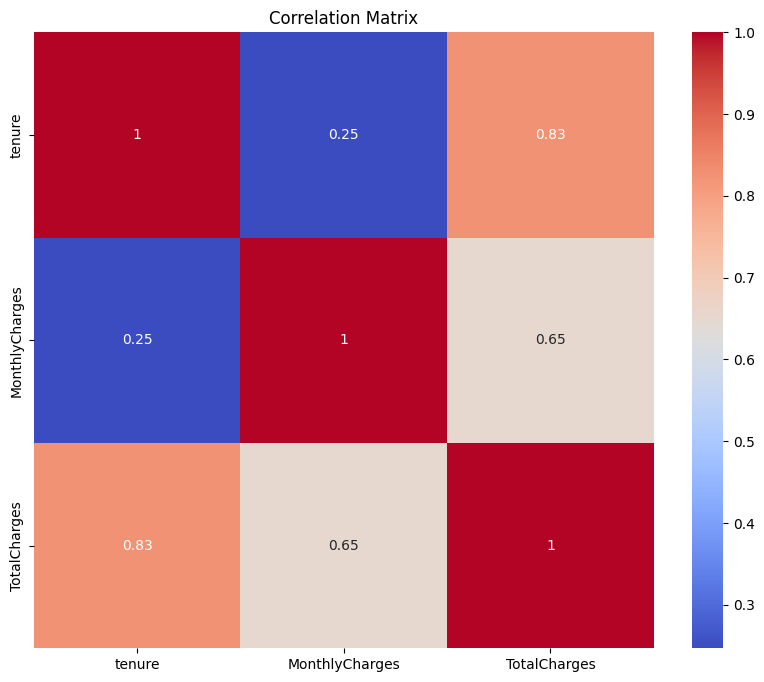

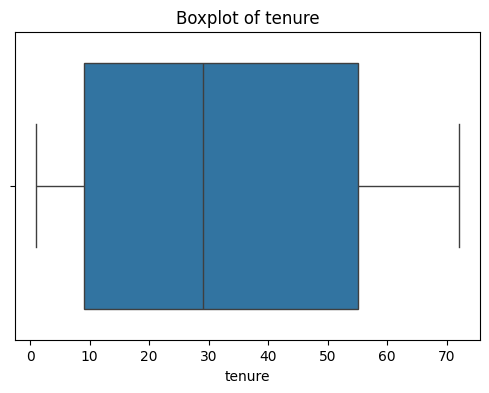

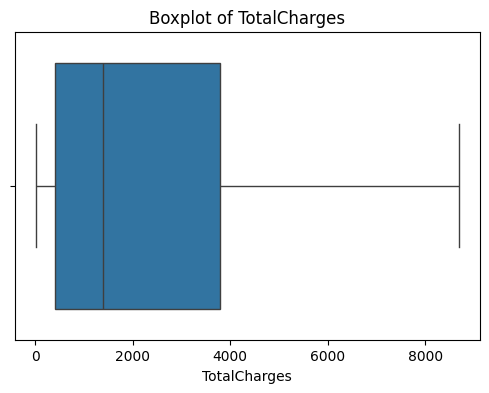

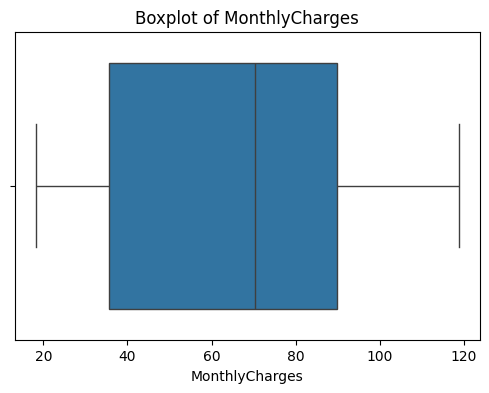

In [6]:
# 2. Exploratory Data Analysis (EDA)

# Descriptive statistics
display(df.describe())

# Check for missing values
print('Missing values in each column:')
print(df.isnull().sum())

# Visualize correlation matrix for numeric features
# Select only numeric features for correlation calculation
numeric_df = df.select_dtypes(include=np.number)
plt.figure(figsize=(10,8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Boxplots to identify outliers in numeric columns
numeric_cols = ['tenure', 'TotalCharges', 'MonthlyCharges']
for col in numeric_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()


# Data Pre-Processing

In [7]:
# 3. Feature Engineering

## Missing Value Treatment
# For numeric columns, impute missing values with the median; for categorical, use the mode.
for col in df.columns:
    if df[col].isnull().sum() > 0:
        if df[col].dtype.name in ['float64', 'int64']:
            df[col].fillna(df[col].median(), inplace=True)
        else:
            df[col].fillna(df[col].mode()[0], inplace=True)

## Outlier Removal using IQR Method for selected numeric columns
def remove_outliers(data, col):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[col] >= lower_bound) & (data[col] <= upper_bound)]

# Remove outliers for key numeric columns
for col in ['tenure', 'TotalCharges', 'MonthlyCharges']:
    initial_shape = df.shape
    df = remove_outliers(df, col)
    print(f"After removing outliers from {col}: shape changed from {initial_shape} to {df.shape}")

## Encoding: One-hot encode the categorical variables
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

print('Data shape after encoding:', df.shape)

After removing outliers from tenure: shape changed from (7032, 20) to (7032, 20)
After removing outliers from TotalCharges: shape changed from (7032, 20) to (7032, 20)
After removing outliers from MonthlyCharges: shape changed from (7032, 20) to (7032, 20)
Data shape after encoding: (7032, 31)


# Handling Class Imbalance Using Smote

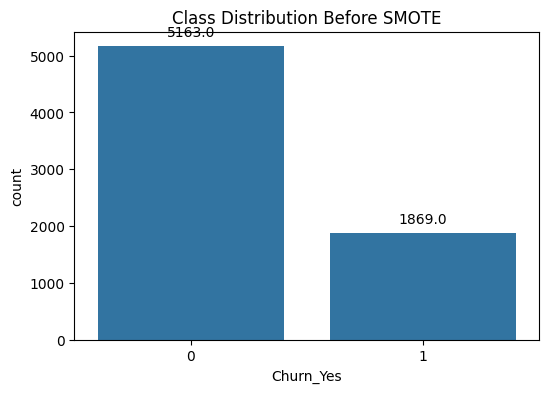

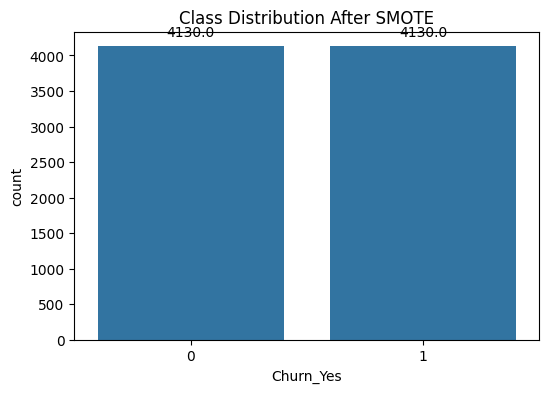

In [8]:
# 4. Handling Class Imbalance with SMOTE

## Visualize class distribution before SMOTE
plt.figure(figsize=(6,4))
ax = sns.countplot(x='Churn_Yes', data=df)
plt.title('Class Distribution Before SMOTE')

# Add labels to the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

## Split data into features and target
X = df.drop('Churn_Yes', axis=1)
y = df['Churn_Yes']

## Split into training and test sets (using stratification on target)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Apply SMOTE on training set
smote = SMOTE(random_state=42)

X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

## Visualize class distribution after SMOTE
plt.figure(figsize=(6,4))
ax = sns.countplot(x=y_train_res)
plt.title('Class Distribution After SMOTE')

# Add labels to the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

# First Model Iteration

In [9]:
#model performances and feature importances for all models 

models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'KNN': KNeighborsClassifier(),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42),
    'LightGBM': LGBMClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
}

# Dictionary to store evaluation metrics
results = {}
feature_importance = {}

for name, model in models.items():
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test)
    
    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred)
    }
    
    print(f"Model: {name}")
    print(classification_report(y_test, y_pred))
    print('-'*40)

# Display evaluation results
results_df = pd.DataFrame(results).T
print("Evaluation Metrics:")
print(results_df)

# Dictionary to store feature importances
feature_importance = {}

# Extract feature importance for models that support it
for name, model in models.items():
    if hasattr(model, "feature_importances_"):  # Check if the model has feature_importances_
        feature_importance[name] = model.feature_importances_

# Convert to DataFrame
if feature_importance:
    feature_importance_df = pd.DataFrame(feature_importance, index=X_train.columns)
    
    # Convert to percentage
    feature_importance_percent_df = feature_importance_df.div(feature_importance_df.sum(axis=0), axis=1) * 100
    feature_importance_percent_df = feature_importance_percent_df.sort_values(by=feature_importance_percent_df.columns.tolist(), ascending=False)
    print("\nFeature Importance (Percentage) Table:")
    print(feature_importance_percent_df)
    


Model: LogisticRegression
              precision    recall  f1-score   support

           0       0.87      0.81      0.84      1033
           1       0.56      0.68      0.61       374

    accuracy                           0.77      1407
   macro avg       0.72      0.74      0.73      1407
weighted avg       0.79      0.77      0.78      1407

----------------------------------------
Model: KNN
              precision    recall  f1-score   support

           0       0.85      0.70      0.77      1033
           1       0.44      0.65      0.53       374

    accuracy                           0.69      1407
   macro avg       0.64      0.68      0.65      1407
weighted avg       0.74      0.69      0.70      1407

----------------------------------------
Model: DecisionTree
              precision    recall  f1-score   support

           0       0.83      0.77      0.80      1033
           1       0.47      0.57      0.52       374

    accuracy                           0.72

# Feature Selection

In [10]:
# Select important features based on various models' feature importance
selected_features = [
    'TotalCharges',
    'MonthlyCharges',
    'tenure',
    'Contract_One year',
    'Contract_Two year'
]


# Keep only these selected features (including log-transformed ones)
X_train_selected = X_train_res[selected_features]
X_test_selected = X_test[selected_features]

# Print the selected features
print("Selected Features:", selected_features)


Selected Features: ['TotalCharges', 'MonthlyCharges', 'tenure', 'Contract_One year', 'Contract_Two year']


# Models after Feature Selection

In [11]:
# Keep only the selected important features
X_train_selected = X_train_res[selected_features]
X_test_selected = X_test[selected_features]

print("Selected Features:", selected_features)


# Train and evaluate models
for name, model in models.items():
    model.fit(X_train_selected, y_train_res)
    y_pred = model.predict(X_test_selected)
    
    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred)
    }

# Show results
results_df = pd.DataFrame(results).T
print("\nEvaluation Metrics After Feature Selection:")
print(results_df)


Selected Features: ['TotalCharges', 'MonthlyCharges', 'tenure', 'Contract_One year', 'Contract_Two year']
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4130, number of negative: 4130
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000147 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 587
[LightGBM] [Info] Number of data points in the train set: 8260, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

Evaluation Metrics After Feature Selection:
                    Accuracy  Precision    Recall  F1 Score
LogisticRegression  0.709311   0.473525  0.836898  0.604831
KNN                 0.691542   0.444238  0.639037  0.524123
DecisionTree        0.705046   0.457557  0.590909  0.515753
RandomForest        0.732765   0.497917  0.639037  0.559719
XGBoost             0.722104   0.48

# Hyperparameter Tuning

In [12]:
# 6. Hyperparameter Tuning

# Define parameter grids for hyperparameter tuning
param_grids = {
      'GradientBoosting': {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1, 0.2]},
      'XGBoost': {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]},
      'LightGBM': {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'num_leaves': [31, 50]}
}

tuned_results = {}
best_models = {}

for name, model in models.items():
    if name in param_grids:
        grid = GridSearchCV(model, param_grids[name], scoring='f1', cv=5, n_jobs=-1)
        grid.fit(X_train_res, y_train_res)
        best_model = grid.best_estimator_
        y_pred = best_model.predict(X_test)
        f1 = f1_score(y_test, y_pred)
        tuned_results[name] = f1
        best_models[name] = best_model
        print(f"Tuned {name} F1 Score: {f1:.4f}")

# Identify best model based on F1 Score
best_model_name = max(tuned_results, key=tuned_results.get)
print(f"\nBest model based on F1 Score: {best_model_name} with F1 Score: {tuned_results[best_model_name]:.4f}")


Tuned XGBoost F1 Score: 0.6051
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4130, number of negative: 4130
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000841 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 637
[LightGBM] [Info] Number of data points in the train set: 8260, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Tuned LightGBM F1 Score: 0.5748
Tuned GradientBoosting F1 Score: 0.6114

Best model based on F1 Score: GradientBoosting with F1 Score: 0.6114


# pkl file and ROC Curve

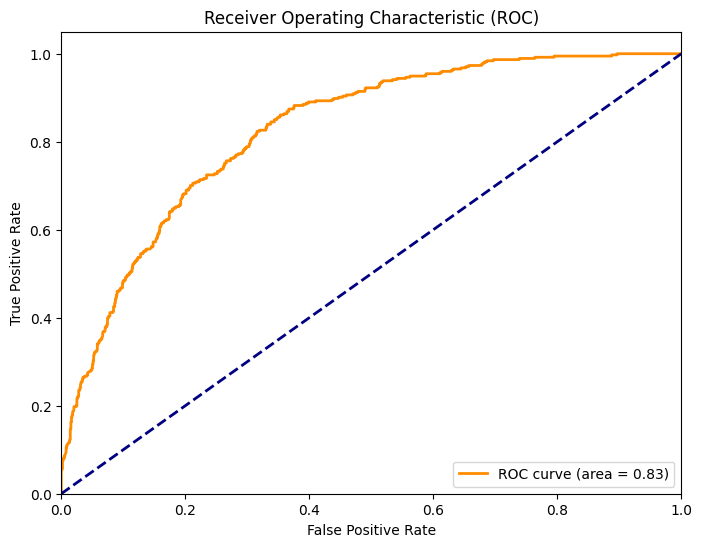

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3304, number of negative: 3304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004931 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 637
[LightGBM] [Info] Number of data points in the train set: 6608, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3304, number of negative: 3304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005496 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 637
[LightGBM] [I

And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 637
[LightGBM] [Info] Number of data points in the train set: 6608, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3304, number of negative: 3304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004885 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 637
[LightGBM] [Info] Number of data points in the train set: 6608, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3304, number of negative: 3304
[Lig

Process LokyProcess-6:
Process LokyProcess-4:
Process LokyProcess-1:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/satya/anaconda3/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/Users/satya/anaconda3/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/satya/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py", line 415, in _process_worker
    is_clean = worker_exit_lock.acquire(True, timeout=30)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt
  File "/Users/satya/anaconda3/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/Users/satya/anaconda3/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/satya/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_

ound whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3304, number of negative: 3304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002691 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 637
[LightGBM] [Info] Number of data points in the train set: 6608, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3304, number of negative: 3304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003505 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 637
[LightGBM] [Info] Number of data po

In [13]:
# 7. Save the Best Model and Plot ROC-AUC Curve

# Save the best model
filename = 'best_churn_predictor_model.pkl'
# save the model to the current directory
with open(filename, "wb") as f:
    pickle.dump(best_models[best_model_name], f) # replace 'log_reg_model' with the name of your model variable

# Plot ROC-AUC curve for the best model
best_model = best_models[best_model_name]
y_proba = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()


# Conclusion

In this notebook, we have:
- Imported and preprocessed the telecom churn dataset according to the data dictionary.
- Performed EDA, including descriptive statistics, missing value and outlier analysis, and correlation visualization.
- Conducted feature engineering by imputing missing values, removing outliers using the IQR method, and encoding categorical variables.
- Addressed class imbalance with SMOTE, visualizing the class distribution before and after upsampling.
- Built and evaluated various classification models, reporting accuracy, precision, recall, and F1 scores.
- Performed hyperparameter tuning to select the best model based on F1 score and explainability.
- Saved the best model as a pickle file and plotted its ROC-AUC curve.



The analysis of customer churn prediction highlighted **GradientBoosting** as the best-performing model, achieving an F1 score of **0.6114**. This model outperformed others, including XGBoost, LightGBM, and Random Forest, based on F1 score.

The most important features for predicting churn were:
- `TotalCharges`
- `MonthlyCharges`
- `tenure`
- `Contract_One year`
- `Contract_Two year`

These features showed consistent importance across models, indicating their strong predictive power. 

While the GradientBoosting model performed the best, **LightGBM** also performed well with an F1 score of **0.5748**, providing a good alternative. 

## Recommendations:
- **GradientBoosting** is recommended for deployment, but **LightGBM** can be considered for faster computation and handling of large datasets.
- Future improvements could involve more feature engineering, such as interactions or transformations, and hyperparameter tuning to further optimize model performance.